# A basic implementation of Echo State Network

**Welcome!** 👋
In this project, we aim to help you understand and build a basic version of an Echo state Network (ESN) and using it to forcast the future values of the *Mackey-Glass time series*, a well known chaotic system. Through this notebook, you will gain hands-on experience in applying a reservoir computing approach to a challenging time series prediction task.

## What You Will Learn

1. **Mackey-Glass Time Series:**  
   We will introduce the Mackey-Glass series, describing its generation process and its characteristic chaotic behavior. You will also learn why it's frequently used as a benchmark for forecasting models.

2. **Echo State Networks (ESNs):**  
   You will get a conceptual overview of ESNs: what the reservoir is, how we control its dynamics through the spectral radius and input scaling, and why we can train the output layer with a simple linear regression approach rather than backpropagation.

3. **Practical Steps to Implementation:**  
   - How to generate and prepare the Mackey-Glass data (normalization, train-test split).  
   - How to initialize and run the ESN.  
   - How to train the readout weights using ridge regression.  
   - How to visualize and evaluate the ESN's performance on unseen data.

## Why ESNs?

Echo State Networks offer a unique combination of simplicity and power. They avoid some complexities of traditional recurrent networks by fixing the recurrent weights and training only the output layer. This leads to:

- **Efficient Training:** No need for complex backpropagation through time.  
- **Rich Dynamics:** The reservoir's random, recurrent structure can model a wide range of temporal patterns.  
- **Flexibility:** ESNs can be applied to many sequence-related problems with minimal adjustments.

## The Goal

By the end of this notebook, you will have a working ESN applied to a challenging nonlinear time series. Beyond just code execution, you will deepen your understanding of the underlying concepts, empowering you to experiment with different parameter settings and datasets.

---




## Background on Echo State Networks

### What is Reservoir Computing?

Reservoir computing is a computational framework derived from several recurrent neural network models. It is a model suited for temporal or sequential data processing, like time-series prediction, speech recognition and system modelling. Generally, a reservoir computing system will consist of a reservoir for mapping inputs, and a readout for pattern analysis. Reservoir computing often uses randomly connected networks to capture complex dynamics.  
A good reservoir system should be able to separate inputs. This is called separability condition.

### Key Concepts in Echo State Networks (ESNs)

1. **Reservoir:**  
   The reservoir is a large set of interconnected neurons with fixed and non-trainable random weights. When you feed time series data into the reservoir, it produces complex, nonlinear responses over time. This internal state can be thought of as a dynamic memory that retains information about recent inputs.

2. **Spectral Radius:**  
   The spectral radius is the largest absolute value of the reservoir's weight matrix eigenvalues. It controls the reservoir's stability and how signals propagate and fade over time. Typically, it's set to a value slightly less than 1 to ensure that the echo states eventually die out and don't explode. To make sense of this, consider a body of water like a pond, when a pebble is dropped into the water it produces ripples that eventually get weaker and disappear. This is what we try to simulate

3. **Input Weights:**  
   The input weights determine how external inputs drive the reservoir. Scaling these appropriately ensures the reservoir receives a meaningful range of values, neither saturating nor ignoring the input.

4. **Output (Readout) Weights:**  
   After passing the input through the reservoir, we train a set of linear output weights to map the reservoir's state to the desired target output. Because this is a simple linear regression problem, it's easy and fast to solve without backpropagating through the entire network.

### Why ESNs?

ESNs are popular for time series forecasting because they simplify training. Since you only adjust the readout weights, you avoid complex backpropagation through time. This efficiency is especially appealing for long sequences or chaotic data. ESNs can capture rich temporal patterns thanks to their large, random reservoir, and they often perform well on challenging nonlinear forecasting tasks.

### Key Parameters to Consider

- **Reservoir Size:**  
  The number of neurons in the reservoir. A larger reservoir might capture more complex dynamics but will be more computationally expensive.

- **Spectral Radius:**  
  Typically chosen slightly less than 1.0 to maintain the echo state property and stable dynamics.

- **Leaking Rate:**  
  Controls how quickly the reservoir's state is updated. A lower leaking rate slows down state changes, providing a longer “memory” of the past.

- **Regularization:**  
  When training the readout weights, adding ridge regression (L2 regularization) can prevent overfitting and improve generalization.

## Mackey-Glass Time Series

The Mackey-Glass time series comes from a mathematical equation that defines how certain quantities, like blood cells, change over time with a delay. Basically, it is able to model a system whose values depend on the current values as well as those that occurred a while ago. THis gives it a "memory" effect which makes it look chaotic even though it depends on a fixed equation

**Why is it used as a benchmark?**  

The Mackey-Glass series looks irregular and can be hard to predict which makes it an excellent test for evaluating forecasting methods. If a model can handle the Mackey-Glass series, it's likely capable of dealing with other challenging, real-world sequences.

---

## Environment Setup

Before we begin, let's make sure we have all the required dependencies installed. For this tutorial, we will be using:

- **NumPy:** For numerical computations and handling arrays.
- **Matplotlib:** For plotting the time series and visualization of predictions.

If you are running this notebook locally and don’t have these packages, you can install them directly from within the notebook. If you are running on an environment like Google Colab or a pre-configured environment, these should already be available.

Run the cell below if you need to install or upgrade any of these packages.


In [1]:
%pip install numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


## Generate and Prepare the Mackey-Glass Data

In this section, we will:

1. **Generate the Mackey-Glass time series:**  
   We will use a function to approximate the Mackey-Glass differential equation and produce a series of values.  
   
2. **Normalize the data:**  
   Normalization ensures that the input values are on a similar scale, which helps stabilize the training and improves the performance of the ESN.

3. **Split into Training and Test Sets:**  
   We will use the first portion of the data for training the ESN and the remaining portion for testing the model’s forecasting ability.



In [2]:
import numpy as np

def generate_mackey_glass(beta=0.2, gamma=0.1, tau=17, n_samples=3000, delta_t=1.0, seed=42):
    """
    Generate Mackey-Glass time series using a discrete approximation.
    Parameters
    ----------
    beta, gamma : float
        Parameters of the Mackey-Glass equation.
        beta controls how strongly the delayed input contributes to the system's growth.
        gamma controls how quickly the current value of x decays or is lost over time
    tau : int
        Time delay paramter. How long it takes for the past state to influence the current state
    n_samples : int
        Length of the time series to generate.
    delta_t : float
        Time step increment for the approximation.
    seed : int
        Random seed for reproducibility.
    
    Returns
    -------
    x : np.ndarray
        Generated Mackey-Glass time series of length n_samples.
    """
    
    np.random.seed(42)
    # We need a history array of length n_samples+tau to allow for delayed referencing
    x = np.zeros(n_samples + tau)
    # Initialize with some random values to start (you can also initialize with a constant)
    # We do this because the equation needs to have some "history"
    x[:tau] = 1.5 + 0.2 * np.random.randn(tau)
    # Implementing of the equation
    for t in range(tau, n_samples + tau - 1):
        x_tau = x[t - tau]
        dx = (beta * x_tau / (1 + x_tau**10)) - gamma * x[t]
        x[t+1] = x[t] + dx * delta_t

    # Return only the portion after the initial transient
    return x[tau:]

# Generate the Mackey-Glass series
data = generate_mackey_glass(n_samples=3000)

# Normalize the data
data_mean = np.mean(data)
data_std = np.std(data)
data = (data - data_mean) / data_std

# Split into train and test sets
train_fraction = 0.7
train_size = int(len(data)*train_fraction)
train_data = data[:train_size]
test_data = data[train_size:]

print("Train data length:", len(train_data))
print("Test data length:", len(test_data))


Train data length: 2100
Test data length: 900


## ESN Implementation

In this section, we will describe the key steps involved in setting up and using an Echo State Network:

1. **Initializing the Reservoir and Weights:**
   - We create a random recurrent weight matrix `W` for the reservoir and an input weight matrix `Win`.
   - The reservoir’s hidden states are not trained directly, only the output layer weights will be learned.

2. **Adjusting the Spectral Radius:**
   - We rescale the reservoir weight matrix `W` so that its largest eigenvalue (spectral radius) is slightly less than 1.
   - This ensures stability and the "echo state property," meaning that the internal states will not explode or vanish over time. (remember the pond analogy)

3. **Updating Reservoir States Given Input:**
   - At each time step, we feed the current input into the reservoir.
   - The reservoir state `x` is updated with a combination of the previous state, the new input, and the recurrent dynamics.
   - A “leaking rate” can control how fast the reservoir state changes.

4. **Collecting States for Training the Readout Layer:**
   - As we run the reservoir on the training data, we record all reservoir states.
   - We then use these recorded states (and the known target outputs) to solve a simple linear regression problem for the readout weights.

5. **Using Ridge Regression to Compute Readout Weights:**
   - Once we have a matrix of collected states and a vector of training targets, we use ridge regression (linear regression with L2 regularization) to find `Wout`.
   - `Wout` is the set of weights from the reservoir states to the output, and it is the only part of the ESN that gets trained.

Once the ESN is set up and `Wout` is computed, the network is ready to make predictions: it can generate outputs for new inputs by just updating the reservoir states and applying `Wout`.


In [3]:
import numpy as np
from numpy.linalg import pinv

# ESN Hyperparameters
input_dim = 1
reservoir_size = 200
output_dim = 1
spectral_radius = 0.95
input_scaling = 0.1
leaking_rate = 1.0
ridge_reg = 1e-6  # Regularization parameter for ridge regression

# Initialize input and reservoir weights
Win = (np.random.rand(reservoir_size, input_dim) - 0.5) * 2 * input_scaling
W = np.random.rand(reservoir_size, reservoir_size) - 0.5

# Adjust spectral radius
rhoW = max(abs(np.linalg.eigvals(W)))
W *= (spectral_radius / rhoW)

# At this point, the ESN is initialized. There will be no output for this cell
# We haven't trained Wout yet, that will happen after we collect reservoir states on the training data. 


## Training the ESN on Mackey-Glass Data

To train the ESN:

1. **Run the ESN on the Training Data:**
   - We feed the training input sequence (except the last point of `train_data`) into the reservoir one step at a time.
   - At each step, we update the reservoir state and store it.

2. **Collect Reservoir States:**
   - After processing the entire training set, we have a large matrix of reservoir states.
   - The corresponding target outputs are the next time steps of `train_data`, i.e., `train_data[1:]`.

3. **Train the Readout (Wout) Using Ridge Regression:**
   - With the states (`X`) and targets (`Y`) known, we solve for `Wout` using ridge regression.
   - This gives us a direct, closed-form solution for the readout weights.

After this, the ESN is fully trained. We can then test it on unseen data.


In [ ]:
# Prepare training input and targets
train_input = train_data[:-1].reshape(-1, 1)
train_target = train_data[1:].reshape(-1, 1)  # keep as (N-1, 1), no transpose

# Initialize reservoir state
x = np.zeros((reservoir_size, 1))

# Collect states
X = []
for u in train_input:
    # Update reservoir state
    x = (1 - leaking_rate)*x + leaking_rate*np.tanh(Win @ u.reshape(-1,1) + W @ x)
    X.append(x.flatten())

X = np.array(X)  # shape: (N-1, reservoir_size)

# Add bias term to the state matrix
X_with_bias = np.hstack([X, np.ones((X.shape[0], 1))])  # (N-1, reservoir_size+1)

# Compute Wout using ridge regression
X_pinv = pinv(X_with_bias, rcond=ridge_reg)   # shape: (reservoir_size+1, N-1)
Wout = X_pinv @ train_target  # (reservoir_size+1, N-1) @ (N-1, 1) = (reservoir_size+1, 1)

print("Training completed. Wout shape:", Wout.shape)


Training completed. Wout shape: (201, 1)


## Testing the ESN

Now that we have trained the readout weights `Wout`, we can test the ESN on the unseen test data:

1. **Run the ESN in Test Mode:**
   - We reset the reservoir state to zero or let it settle.
   - Feed the test input sequence (all but the last point of `test_data`) step-by-step into the reservoir.
   - At each step, use the trained `Wout` to predict the next value.

2. **Generate Predictions:**
   - Store the predictions and then compare them to the actual `test_data` values.
   - We can visualize both the true and predicted series to assess performance.


In [ ]:
# Prepare test input and targets
test_input = test_data[:-1].reshape(-1,1)
test_target = test_data[1:].reshape(-1,1)

# Reset the reservoir state for testing
x = np.zeros((reservoir_size,1))
Y_pred = []

for u in test_input:
    x = (1 - leaking_rate)*x + leaking_rate*np.tanh(Win @ u.reshape(-1,1) + W @ x)
    x_with_bias = np.vstack([x, [[1]]])  # add bias term
    y = Wout.T @ x_with_bias
    Y_pred.append(y.flatten())

Y_pred = np.array(Y_pred)  # shape: (test_samples, 1)

print("Testing completed. Predictions shape:", Y_pred.shape)


Testing completed. Predictions shape: (899, 1)


## Results and Visualization

Now that we have predictions for the test set, we need to visualize and assess how well the ESN performed.

**Metrics and Visualization:**

- **Plotting True vs. Predicted Values:**  
  By plotting the model’s predictions against the actual Mackey-Glass values, we can visually inspect if the model is accurately capturing the time series dynamics.  
  Look for how closely the predicted line follows the true data line. Are the peaks and troughs aligned?

- **Error Metrics (e.g., RMSE):**  
  The **Root Mean Squared Error (RMSE)** is a common metric to quantify prediction accuracy.
  A lower RMSE indicates better performance.

We normalized the data earlier, so the RMSE will be in normalized units. For interpretability, we could also de-normalize predictions and targets before comparing, but that’s optional. 


Test RMSE (normalized): 0.17082138696256569


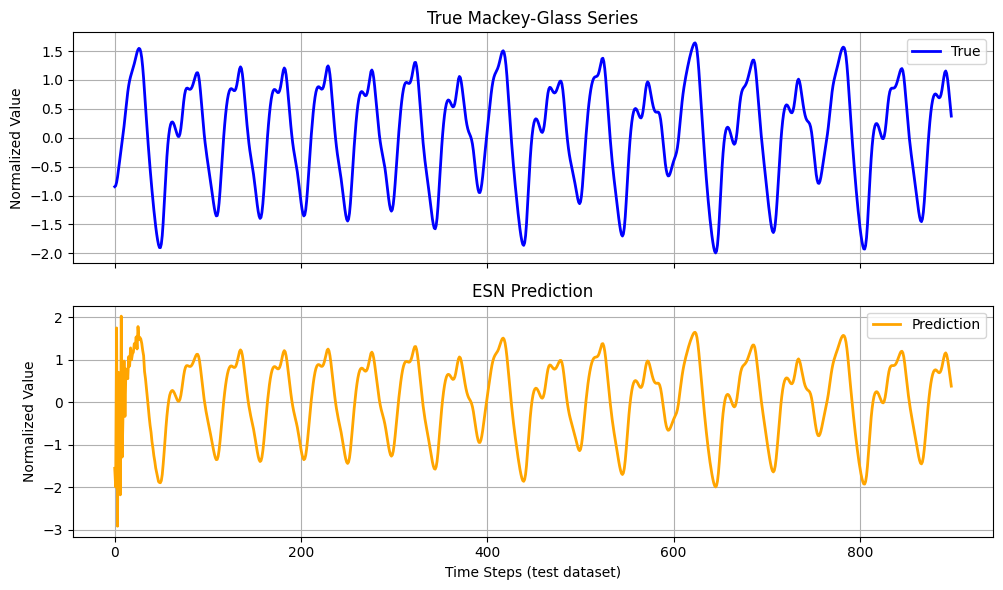

In [ ]:
import matplotlib.pyplot as plt

# Compute RMSE
mse = np.mean((Y_pred - test_target)**2)
rmse = np.sqrt(mse)
print("Test RMSE (normalized):", rmse)

# Create a time index for plotting
t = np.arange(len(test_target))

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot the true values on the first subplot
axs[0].plot(t, test_target, label='True', linewidth=2, color='blue')
axs[0].set_title('True Mackey-Glass Series')
axs[0].set_ylabel('Normalized Value')
axs[0].grid(True)
axs[0].legend()

# Plot the predictions on the second subplot
axs[1].plot(t, Y_pred, label='Prediction', linewidth=2, color='orange')
axs[1].set_title('ESN Prediction')
axs[1].set_xlabel('Time Steps (test dataset)')
axs[1].set_ylabel('Normalized Value')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


## Discussion of Results

The Echo State Network’s predictions for the Mackey-Glass time series closely match the true values, as illustrated by the overlapping plots and a low RMSE score (around 0.17 in normalized terms). This level of accuracy suggests that the ESN successfully captured the underlying dynamics of the time series. Such results are not unheard of, especially on a well-understood benchmark like Mackey-Glass, where certain parameter choices make it relatively easier for the model to produce near-perfect forecasts.

It’s important to note that ESN performance can be sensitive to key hyperparameters, such as the reservoir size, spectral radius, leaking rate, and the amount of regularization. The specific value of parameters we chose can be cosidered a "standard" as we have seen the same values in various examples. Adjusting these parameters can lead to different levels of accuracy or stability. A larger reservoir might capture more complex dynamics, while a carefully chosen spectral radius ensures that the reservoir’s internal states remain stable over time. Similarly, varying the regularization strength can help prevent overfitting and improve generalization, especially when dealing with noisier or more complex datasets.

By experimenting with these parameters, you can often achieve a balance between model complexity, stability, and predictive performance.

## Conclusion

In this notebook, we:

- Introduced the Mackey-Glass time series and discussed its properties as a benchmark for nonlinear and chaotic time series prediction.
- Explained the principles of Echo State Networks, including the reservoir concept, spectral radius, and readout layer training.
- Implemented an ESN from scratch, including data generation, normalization, training the readout weights with ridge regression, and evaluating predictions against a test set.
- Observed that the ESN can produce highly accurate forecasts on the Mackey-Glass series, demonstrating the effectiveness of reservoir computing in time series forecasting.

Thankyou so much for reading this notebook! Please feel free to message us on linkedin if you would like to ask a question on this topic or want us to cover something else